<a href="https://colab.research.google.com/github/am610/SN_lsst_analysis/blob/main/Ayan/2_Large_Data_CPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copied from :
# https://github.com/igomezv/SN_lsst_analysis/blob/main/Load_large_model.ipynb

In [2]:
# ! pip install astronn

In [3]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

2024-02-06 19:39:51.423901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 19:39:51.427791: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 19:39:51.491872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 19:39:51.491919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 19:39:51.493390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
!wget 'https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/models/large_lsst_model.h5?token=GHSAT0AAAAAACCZYW3JLNENF2CEPSKYABZ2ZHGGN5Q' -O large_lsst_model.h5


--2024-02-06 19:39:54--  https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/models/large_lsst_model.h5?token=GHSAT0AAAAAACCZYW3JLNENF2CEPSKYABZ2ZHGGN5Q
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-02-06 19:39:55 ERROR 404: Not Found.



In [5]:
# For future loading
# model
# https://drive.google.com/file/d/1Psy8I0YY5Dac37vjUxG53OfoZn3rNhhi/view?usp=drive_link
# hubble_diagram.txt
# https://drive.google.com/file/d/1nsSVfcqe2zKTYmNvFOTPol7l4rEQN2as/view?usp=drive_link

In [6]:
# !wget https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/Data_SNIa_LSST/larger/hubble_diagram.txt?token=GHSAT0AAAAAACCZYW3I54VGIPAT2JASWHPOZHGGUCA -O hubble_diagram.txt


In [7]:
from sklearn.metrics import mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    # MSE
    mse = ((y_true - y_pred) ** 2).mean()

    # RMSE
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    # R^2
    r2 = r2_score(y_true, y_pred)

    # MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R^2": r2,
        "MAPE": mape
    }

In [8]:
model = tf.keras.models.load_model('../models/large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})
df_data = pd.read_csv('../Data_SNIa_LSST/larger/hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

2024-02-06 19:39:55.318564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:39:55.319005: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [9]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [10]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [11]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)

scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



181/181 [==============================] - 0s 2ms/step


In [12]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2

def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.3163
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [13]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(5785, 5785, 5785)

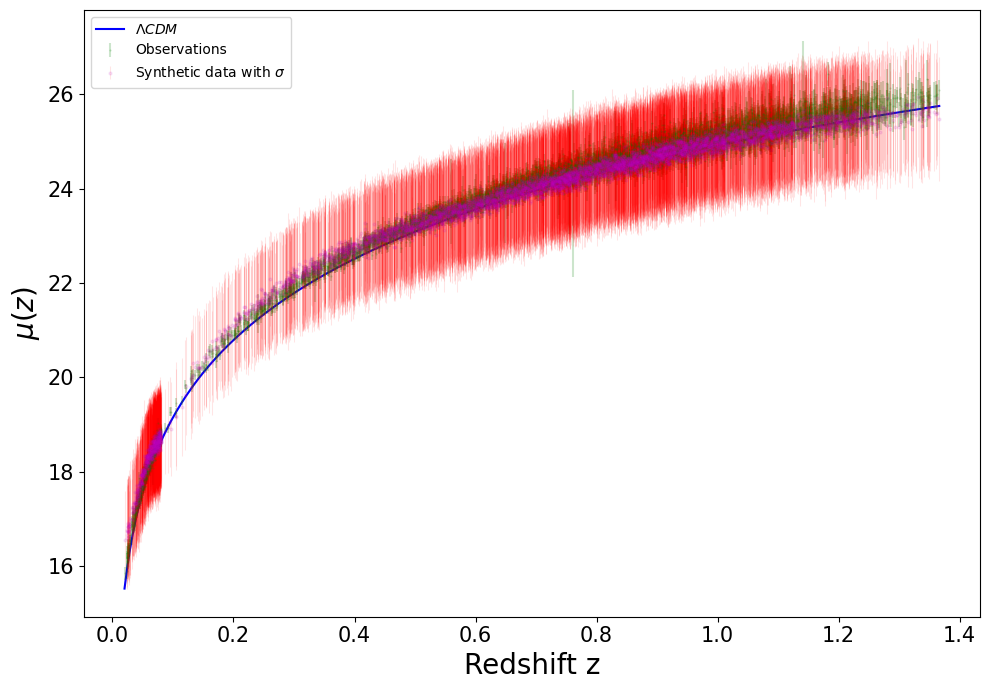

In [14]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o',
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m',
             label='Synthetic data with $\sigma$')

# plt.xlim(zmin-0.01,zmax+0.01)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [15]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values-19, flcdm)
mse_neural = mean_squared_error(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19))
mse_lcdm, mse_neural

(0.0516428839189047, 0.03758693541244855)

#### Metric Comparison

In [16]:
# Lower MAPE is better
# Higher R^2 is better
# MSE, RMSE, MAE lower is better

# LCDM
print(compute_metrics(df_data['MU'].values-19, flcdm))
#NN
print(compute_metrics(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19)))

{'MSE': 8.59255122345656, 'RMSE': 2.931305378744521, 'MAE': 0.1867934435960602, 'R^2': 0.9880181511173348, 'MAPE': 9.017598656840857}
{'MSE': 0.03758693541244855, 'RMSE': 0.19387350363690378, 'MAE': 0.15175074188000306, 'R^2': 0.9912793216431975, 'MAPE': 0.6441339466547511}


In [17]:
print(flcdm)

[array([15.52452407]), array([15.8661585]), array([15.90670787]), array([16.00364866]), array([16.00454359]), array([16.01525499]), array([16.05584944]), array([16.05672385]), array([16.06631998]), array([16.07240539]), array([16.11625253]), array([16.12135535]), array([16.13237201]), array([16.13321722]), array([16.18583656]), array([16.19243138]), array([16.2340263]), array([16.23725646]), array([16.24289814]), array([16.30717567]), array([16.31264563]), array([16.31654466]), array([16.35287058]), array([16.55026028]), array([16.57124572]), array([16.62287641]), array([16.64724862]), array([16.65061308]), array([16.67002942]), array([16.68795896]), array([16.69390422]), array([16.74865729]), array([16.75893887]), array([16.76342252]), array([16.78444173]), array([16.82029749]), array([16.84141989]), array([16.85129262]), array([16.8635738]), array([16.86907885]), array([16.87822457]), array([16.9311545]), array([16.93353154]), array([16.9636242]), array([16.97939684]), array([16.9811

ValueError: too many values to unpack (expected 1)

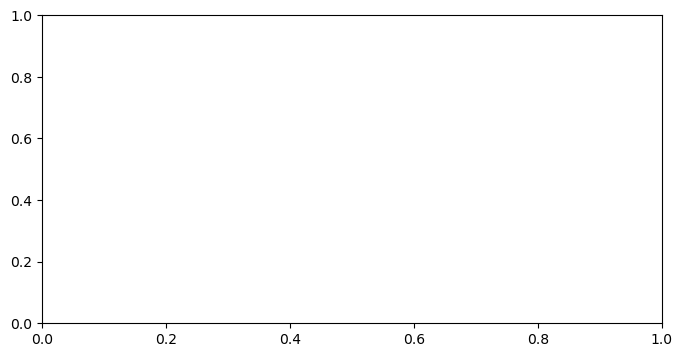

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

flcdm_1d = np.array([item for item in flcdm])
flcdm = flcdm_1d
# Compute residuals
residuals_lcdm = df_data['MU'].values - (flcdm +19)
residuals_neural = df_data['MU'].values - prediction_mc_dropout[:,0]

# Create a figure and set up a gridspec for the main plot and residuals
plt.figure(figsize=(8,4))
# Residual plot
plt.errorbar(df_data['zCMB'], residuals_lcdm, df_data['errors'],
             fmt='b.', markersize=1, alpha=0.2, label=f'LCDM Mean: {np.mean(residuals_lcdm):.2f}, Std: {np.std(residuals_lcdm):.2f}')
plt.errorbar(df_data['zCMB'], residuals_neural, df_data['errors'],
             fmt='r.', markersize=1, alpha=0.2, label=f'NN Mean: {np.mean(residuals_neural):.2f}, Std: {np.std(residuals_neural):.2f}')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Redshift z", fontsize=20)
plt.ylabel("$\\Delta \\mu$", fontsize=20)
plt.legend()
plt.grid(False)
#sns.despine(ax=ax_resid)

plt.tight_layout()
plt.show()

In [ ]:
#np.sort(prediction_mc_dropout[:,0])-19

In [ ]:
#np.sort(df_data['MU'].values)-19

In [ ]:
# Diagnosing the shapes of z_or and prediction_mc_dropout[0]
#shape_z_or = z_or.shape
#shape_prediction = prediction_mc_dropout[:,0].shape
#shape_z_or, shape_prediction


# CPL

In [ ]:
import seaborn as sns
# Define the CPL model functions
def RHSquared_a_cpl(a, w0, wa, Om):
    w = w0 + (1 - a) * wa
    rhow = a**(-3*(1.0+w))
    return (Om/a**3 + (1.0-Om)*rhow)

def DistIntegrand_a_cpl(a, w0, wa, Om):
    return 1./np.sqrt(RHSquared_a_cpl(a, w0, wa, Om))/a**2

def Da_z_cpl(z, w0, wa, Om):
    r = intg.quad(DistIntegrand_a_cpl, 1./(1+z), 1, args=(w0, wa, Om))
    return r[0]

def distance_modulus_cpl(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z_cpl(z, w0, wa, Om)*(1+z))+24

# Calculate the CPL model values
f_cpl = [distance_modulus_cpl(zzz[0], w0=-1, wa=0, Om=om) for zzz in z_or]

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# Plotting with Seaborn
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
sns.despine(left=True)
plt.plot(z_or, f_cpl, label='CPL model', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m', label='Synthetic data with $\sigma$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(False)

plt.show()
# Evaluate the CPL model
mse_cpl = mean_squared_error(df_data['MU'].values-19, f_cpl)
print("MSE for CPL model:", mse_cpl)


In [ ]:
import matplotlib.gridspec as gridspec

# Calculate residuals for the CPL model
residuals_cpl = np.array(f_cpl) - (df_data['MU'].values - 19)
# Calculate mean and standard deviation of the residuals
mean_residuals = np.mean(residuals_cpl)
std_residuals = np.std(residuals_cpl)


# Create a gridspec for the main plot and the residuals
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax_main = plt.subplot(gs[0])
ax_resid = plt.subplot(gs[1], sharex=ax_main)

# Main plot
ax_main.plot(z_or, f_cpl, label='CPL model', c='b')
ax_main.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
ax_main.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m', label='Synthetic data with $\sigma$')
ax_main.set_ylabel("$\mu(z)$", fontsize=20)
ax_main.legend(loc='upper left')
ax_main.grid(False)
sns.despine(ax=ax_main)

# Residual plot
ax_resid.errorbar(df_data['zCMB'], residuals_cpl, df_data['errors'], fmt='g.', markersize=1, alpha=0.2,label=f'Mean: {mean_residuals:.2f}, Std: {std_residuals:.2f}')
ax_resid.axhline(0, color='black', linestyle='--')  # Zero line for reference
ax_resid.set_xlabel("Redshift z", fontsize=20)
ax_resid.set_ylabel("$\Delta \mu$", fontsize=20)
ax_resid.grid(False)
sns.despine(ax=ax_resid)

# Adjust layout and show
plt.tight_layout()
plt.legend()
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Already defined above
# Calculate residuals for the CPL model
#residuals_cpl = np.array(f_cpl) - (df_data['MU'].values - 19)
# Calculate mean and standard deviation of the residuals
#mean_residuals = np.mean(residuals_cpl)
#std_residuals = np.std(residuals_cpl)


# Compute residuals
residuals_neural = df_data['MU'].values - prediction_mc_dropout[:,0]

# Create a figure and set up a gridspec for the main plot and residuals
plt.figure(figsize=(8,4))
# Residual plot
plt.errorbar(df_data['zCMB'], residuals_cpl, df_data['errors'],
             fmt='b.', markersize=1, alpha=0.2, label=f'CPL Mean: {np.mean(residuals_cpl):.2f}, Std: {np.std(residuals_cpl):.2f}')
plt.errorbar(df_data['zCMB'], residuals_neural, df_data['errors'],
             fmt='r.', markersize=1, alpha=0.2, label=f'NN Mean: {np.mean(residuals_neural):.2f}, Std: {np.std(residuals_neural):.2f}')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Redshift z", fontsize=20)
plt.ylabel("$\\Delta \\mu$", fontsize=20)
plt.legend()
plt.grid(False)
#sns.despine(ax=ax_resid)

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import norm


# Calculate residuals for the CPL model
#residuals_cpl = np.array(f_cpl) - (df_data['MU'].values - 19)
# Calculate mean and standard deviation of the residuals
#mean_residuals = np.mean(residuals_cpl)
#std_residuals = np.std(residuals_cpl) # np.mean(residuals_neural)


# Computing the Gaussian curve using scipy's norm.pdf function
gaussian_curve_scipy = norm.pdf(residuals_cpl, mean_residuals, std_residuals)
gaussian_curve_scipy_nn = norm.pdf((residuals_neural), np.mean(residuals_neural), np.std(residuals_neural))

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(residuals_cpl, gaussian_curve_scipy, '.',color='blue', label='CPL  $\mu=%.2f,\sigma=%.2f$'%(mean_residuals, std_residuals))
plt.plot(residuals_neural, gaussian_curve_scipy_nn, '.',color='red', label='NN $\mu=%.2f,\sigma=%.2f$'%(np.mean(residuals_neural), np.std(residuals_neural)))
#plt.hist(sample_data, bins=50, density=True, alpha=0.6, color='gray', label='Sample Data')
plt.axvline(0,linestyle='--',c='black')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Gaussian Distribution of the residuals')
plt.legend()
plt.grid(False)
plt.minorticks_on()

plt.tight_layout()
plt.show()


In [ ]:
# Lower MAPE is better
# Higher R^2 is better
# MSE, RMSE, MAE lower is better

# LCDM
#print(compute_metrics(df_data['MU'].values-19, flcdm))
# CPL
print(compute_metrics(df_data['MU'].values-19, f_cpl))
#NN
print(compute_metrics(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19)))

##### Doin a single number comparison

In [ ]:
# Given model metrics
model1_metrics = {
    'MSE': 0.038229351086070555,
    'RMSE': 0.19552327504946965,
    'MAE': 0.1567536620578353,
    'R^2': 0.991130272501533,
    'MAPE': 0.6628196657291464
}

model2_metrics = {
    'MSE': 0.037702735041251226,
    'RMSE': 0.19417192135128916,
    'MAE': 0.1521894064352683,
    'R^2': 0.9912524545601129,
    'MAPE': 0.6460112315214617
}

# Calculate percentage improvement for each metric
percentage_improvements = []

for key in model1_metrics:
    # For MSE, RMSE, and MAE, lower is better
    if key in ['MSE', 'RMSE', 'MAE', 'MAPE']:
        improvement = (model1_metrics[key] - model2_metrics[key]) / model1_metrics[key] * 100
    # For R^2, higher is better
    else:
        improvement = (model2_metrics[key] - model1_metrics[key]) / model1_metrics[key] * 100

    percentage_improvements.append(improvement)

# Compute average percentage improvement
average_improvement = np.mean(percentage_improvements)

print("Average Improvement = %.2f %%"%(average_improvement))


In [ ]:
# Calculate the percentage difference for each metric
percentage_differences = {}

for key in model1_metrics:
    # For MSE, RMSE, and MAE, lower is better
    if key in ['MSE', 'RMSE', 'MAE', 'MAPE']:
        percentage_difference = (model1_metrics[key] - model2_metrics[key]) / model1_metrics[key] * 100
    # For R^2, higher is better
    else:
        percentage_difference = (model2_metrics[key] - model1_metrics[key]) / model1_metrics[key] * 100

    percentage_differences[key] = percentage_difference

print('%% Differences :')
percentage_differences


In [ ]:
def normalize_metric(metric_value, min_value, max_value, higher_is_better=True):
    """Normalize a metric to the range [0, 1]."""
    if higher_is_better:
        normalized = (metric_value - min_value) / (max_value - min_value)
    else:
        normalized = 1 - (metric_value - min_value) / (max_value - min_value)
    return normalized

# Calculate normalized scores for each metric
normalized_scores_model1 = []
normalized_scores_model2 = []

for key in model1_metrics:
    min_value = min(model1_metrics[key], model2_metrics[key])
    max_value = max(model1_metrics[key], model2_metrics[key])

    # Metrics where higher is better
    if key in ['R^2']:
        normalized_scores_model1.append(normalize_metric(model1_metrics[key], min_value, max_value, True))
        normalized_scores_model2.append(normalize_metric(model2_metrics[key], min_value, max_value, True))
    # Metrics where lower is better
    else:
        normalized_scores_model1.append(normalize_metric(model1_metrics[key], min_value, max_value, False))
        normalized_scores_model2.append(normalize_metric(model2_metrics[key], min_value, max_value, False))

# Compute average normalized scores for each model
average_normalized_score_model1 = np.mean(normalized_scores_model1)
average_normalized_score_model2 = np.mean(normalized_scores_model2)

average_normalized_score_model1, average_normalized_score_model2
